In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from src.conditional_normalizing_flow import ConditionalNormalizingFlow
from src.generate_data_lhc import *
from src.utils import *
from sklearn.model_selection import train_test_split, ShuffleSplit
import time

In [2]:
cd ..

/home/rd804/m-anode


[4 3 1 2]
[2 1 4 3]
[4 3 1 2]


In [3]:
# data loading
data_path = "./data/lhc_co"

SR_data, CR_data, _, _ = resample_split(data_path, resample = False)
#outerdata_train = np.load(join(data_path, "outerdata_train.npy"))
#outerdata_val = np.load(join(data_path, "outerdata_val.npy"))
#innerdata_test = np.load(join(data_path, "innerdata_test.npy"))

using first 1000 signal events for mock_data from 70000 events
sigma=2.216122847373821
true w: 0.006321443778454686


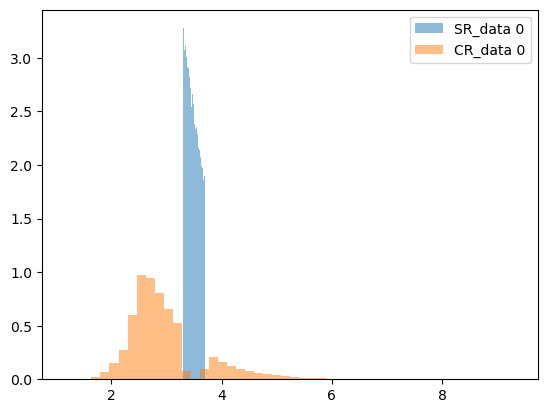

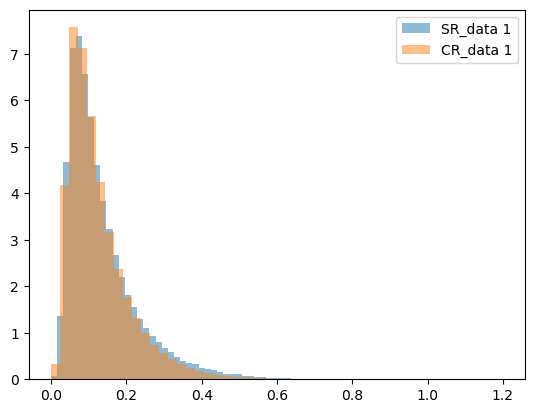

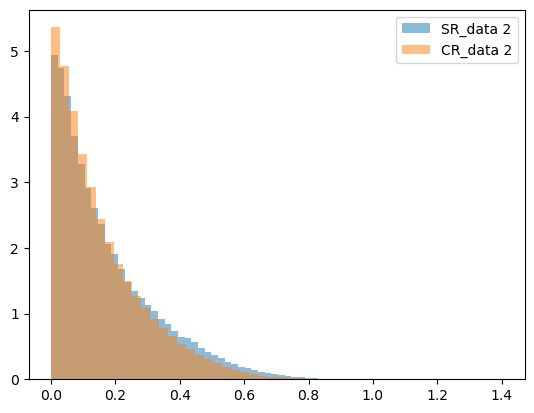

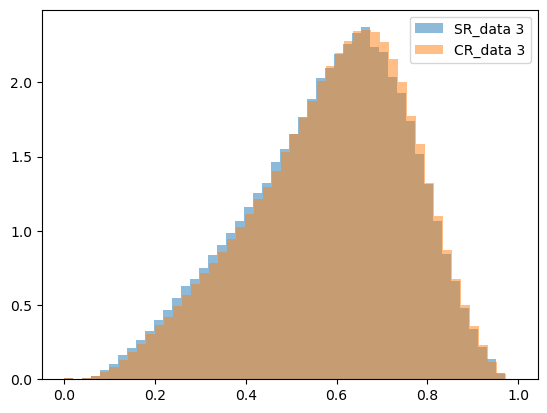

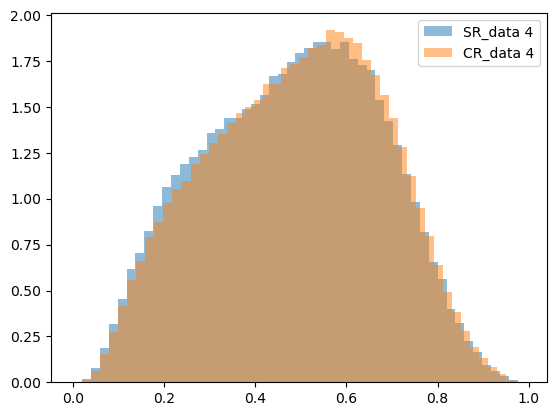

In [4]:
for i in range(5):
    plt.hist(SR_data[:,i][SR_data[:,-1]==0], bins = 50, alpha = 0.5, label = f"SR_data {i}", density=True)
    plt.hist(CR_data[:,i][CR_data[:,-1]==0], bins = 50, alpha = 0.5, label = f"CR_data {i}", density=True)
    plt.legend()
    plt.show()

In [5]:
# some data preprocessing functions
def logit_transform(x, min_vals, max_vals):
    with np.errstate(divide='ignore', invalid='ignore'):
        x_norm = (x - min_vals) / (max_vals - min_vals)
        logit = np.log(x_norm / (1 - x_norm))
    domain_mask = ~(np.isnan(logit).any(axis=1) | np.isinf(logit).any(axis=1))
    return logit, domain_mask

def standardize(x, mean, std):
    return (x - mean) / std

def inverse_logit_transform(x, min_vals, max_vals):
    x_norm = 1 / (1 + np.exp(-x))
    return x_norm * (max_vals - min_vals) + min_vals

def inverse_standardize(x, mean, std):
    return x * std + mean

In [7]:
# data preprocessing

# the logit min/max and standard scaler parameters are derived on the outer train set
preprocessing_params = {}
preprocessing_params["min"] = np.min(CR_data[:, 1:-1], axis=0)
preprocessing_params["max"] = np.max(CR_data[:, 1:-1], axis=0)

preprocessed_outerdata_train_x, mask = logit_transform(CR_data[:, 1:-1], preprocessing_params["min"], preprocessing_params["max"])
preprocessed_outerdata_train = np.hstack([CR_data[:, 0:1], preprocessed_outerdata_train_x, CR_data[:, -1:]])[mask]

preprocessing_params["mean"] = np.mean(preprocessed_outerdata_train[:, 1:-1], axis=0)
preprocessing_params["std"] = np.std(preprocessed_outerdata_train[:, 1:-1], axis=0)
preprocessed_outerdata_train[:, 1:-1] = standardize(preprocessed_outerdata_train[:, 1:-1], preprocessing_params["mean"], preprocessing_params["std"])


In [8]:
preprocessing_params

{'min': array([-3.4119701e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]),
 'max': array([1.19780005, 1.40151595, 0.99389874, 0.99018748]),
 'mean': array([-2.33592563, -2.60241841,  0.41499766, -0.03219697]),
 'std': array([0.70178106, 1.32811469, 0.82166918, 0.89770345])}

In [14]:
data = np.vstack((CR_data,SR_data))
print(data.shape)

(1001000, 6)


In [15]:
pre_parameters = preprocess_params_fit(data)
print(pre_parameters)

pre_parameters_CR = pre_parameters.copy()
pre_parameters_SR = pre_parameters.copy()

{'min': array([-3.4119701e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]), 'max': array([1.19780005, 1.40151595, 0.99389874, 0.99018748]), 'mean': array([-2.32677975, -2.58701271,  0.40950483, -0.03886135]), 'std': array([0.70574795, 1.33138574, 0.82285321, 0.899691  ])}


In [7]:
#pre_parameters_CR = preprocess_params_fit(CR_data)
x_train = preprocess_params_transform(CR_data, pre_parameters_CR) 
# train test split
preprocessed_outerdata_train, preprocessed_outerdata_val = train_test_split(x_train, test_size=0.5, random_state=42)

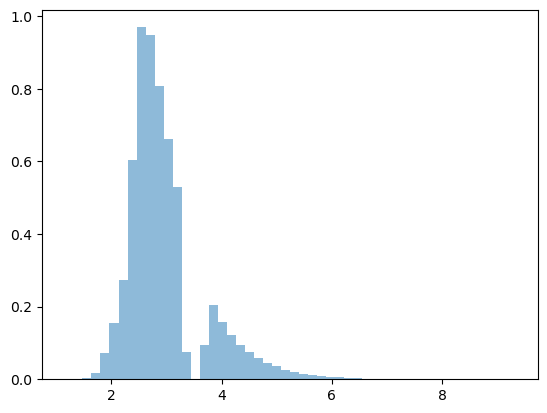

In [10]:
i=0
plt.hist(x_train[:,i], bins = 50, alpha = 0.5, label = f"SR_data {i}", density=True)
plt.show()

In [ ]:


# outer validation set if one wants to train a new flow
#preprocessed_outerdata_val_x, mask = logit_transform(outerdata_val[:, 1:-1], preprocessing_params["min"], preprocessing_params["max"])
#preprocessed_outerdata_val = np.hstack([outerdata_val[:, 0:1], preprocessed_outerdata_val_x, outerdata_val[:, -1:]])[mask]
#preprocessed_outerdata_val[:, 1:-1] = standardize(preprocessed_outerdata_val[:, 1:-1], preprocessing_params["mean"], preprocessing_params["std"])

# inner test set to evaluate inner log likelihood
#preprocessed_innerdata_test_x, mask = logit_transform(innerdata_test[:, 1:-1], preprocessing_params["min"], preprocessing_params["max"])
#preprocessed_innerdata_test = np.hstack([innerdata_test[:, 0:1], preprocessed_innerdata_test_x, innerdata_test[:, -1:]])[mask]
#preprocessed_innerdata_test[:, 1:-1] = standardize(preprocessed_innerdata_test[:, 1:-1], preprocessing_params["mean"], preprocessing_params["std"])

In [8]:
# either train new flow model from scratch
m_train = preprocessed_outerdata_train[:, 0]
x_train = preprocessed_outerdata_train[:, 1:-1]
m_val = preprocessed_outerdata_val[:, 0]
x_val = preprocessed_outerdata_val[:, 1:-1]

flow_savedir = "./model_CR_1/"
model = ConditionalNormalizingFlow(save_path=flow_savedir)


ConditionalNormalizingFlow has 274800 parameters


In [ ]:

start = time.time()
model.fit(m_train, x_train, m_val, x_val, epochs=20, verbose=True)
end = time.time()
print(f"Training took {end-start} seconds")

In [14]:
# after training it still makes sense to go back to the optimal epoch checlpoint
#model.load_best_model()

model

In [6]:
flow_savedir = "./model_CR_1/"
model = ConditionalNormalizingFlow(save_path=flow_savedir)
model.load_best_model()

ConditionalNormalizingFlow has 274800 parameters


In [10]:
#pre_parameters_SR = preprocess_params_fit(SR_data)
x_train = preprocess_params_transform(SR_data, pre_parameters_SR) 
# train test split
preprocessed_innerdata_train, preprocessed_innerdata_val = train_test_split(x_train, test_size=0.5, random_state=42)

In [11]:
m_train = preprocessed_innerdata_train[:, 0]
x_train = preprocessed_innerdata_train[:, 1:-1]
m_val = preprocessed_innerdata_val[:, 0]
x_val = preprocessed_innerdata_val[:, 1:-1]

In [12]:
print('pre parameters CR:', pre_parameters_CR)
print('pre parameters SR:', pre_parameters_SR)

pre parameters CR: {'min': array([-3.4119701e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]), 'max': array([1.19780005, 1.40151595, 0.99389874, 0.99018748]), 'mean': array([-2.32677975, -2.58701271,  0.40950483, -0.03886135]), 'std': array([0.70574795, 1.33138574, 0.82285321, 0.899691  ])}
pre parameters SR: {'min': array([-3.4119701e-08,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00]), 'max': array([1.19780005, 1.40151595, 0.99389874, 0.99018748]), 'mean': array([-2.32677975, -2.58701271,  0.40950483, -0.03886135]), 'std': array([0.70574795, 1.33138574, 0.82285321, 0.899691  ])}


In [6]:
# or loading existing flow model


ConditionalNormalizingFlow has 274800 parameters


In [13]:
flow_savedir = "./models_SR_1/"
model_SR = ConditionalNormalizingFlow(save_path=flow_savedir)


ConditionalNormalizingFlow has 274800 parameters


In [14]:
# train SR model

start = time.time()
model_SR.fit(m_train, x_train, m_val, x_val, epochs=50, verbose=True)
end = time.time()
print(f"Training took {end-start} seconds")

n_nans = 0
n_highs = 0
n_nans = 0
n_highs = 0

Epoch: 0


Train, Log likelihood in nats: -5.504380: 100%|██████████| 61055/61055 [00:13<00:00, 4418.00it/s]


n_nans = 0
n_highs = 0
train_loss =  5.505099269371636
val_loss =  5.461255941430894

Epoch: 1


Train, Log likelihood in nats: -5.423287: 100%|██████████| 61055/61055 [00:13<00:00, 4665.92it/s]


n_nans = 0
n_highs = 0
train_loss =  5.423681663113782
val_loss =  5.442440896852246

Epoch: 2


Train, Log likelihood in nats: -5.415570: 100%|██████████| 61055/61055 [00:13<00:00, 4558.34it/s]


n_nans = 0
n_highs = 0
train_loss =  5.415874687259178
val_loss =  5.43629818281868

Epoch: 3


Train, Log likelihood in nats: -5.411297: 100%|██████████| 61055/61055 [00:13<00:00, 4644.92it/s]


n_nans = 0
n_highs = 0
train_loss =  5.411606708024744
val_loss =  5.43424511155324

Epoch: 4


Train, Log likelihood in nats: -5.409075: 100%|██████████| 61055/61055 [00:12<00:00, 4703.00it/s]


n_nans = 0
n_highs = 0
train_loss =  5.409369345787517
val_loss =  5.436720399178221

Epoch: 5


Train, Log likelihood in nats: -5.408592: 100%|██████████| 61055/61055 [00:12<00:00, 4752.18it/s]


n_nans = 0
n_highs = 0
train_loss =  5.4083374281673855
val_loss =  5.430054614733453

Epoch: 6


Train, Log likelihood in nats: -5.406869: 100%|██████████| 61055/61055 [00:13<00:00, 4556.66it/s]


n_nans = 0
n_highs = 0
train_loss =  5.406681310737097
val_loss =  5.430286403480434

Epoch: 7


Train, Log likelihood in nats: -5.405241: 100%|██████████| 61055/61055 [00:13<00:00, 4648.83it/s]


n_nans = 0
n_highs = 0
train_loss =  5.405305920404002
val_loss =  5.4295160221754255

Epoch: 8


Train, Log likelihood in nats: -5.405261: 100%|██████████| 61055/61055 [00:12<00:00, 4780.63it/s]


n_nans = 0
n_highs = 0
train_loss =  5.405506496969893
val_loss =  5.428933389017272

Epoch: 9


Train, Log likelihood in nats: -5.403128: 100%|██████████| 61055/61055 [00:12<00:00, 4715.58it/s]


n_nans = 0
n_highs = 0
train_loss =  5.403028052906158
val_loss =  5.4284977334313815

Epoch: 10


Train, Log likelihood in nats: -5.402783: 100%|██████████| 61055/61055 [00:13<00:00, 4608.00it/s]


n_nans = 0
n_highs = 0
train_loss =  5.403115605382503
val_loss =  5.432283521197331

Epoch: 11


Train, Log likelihood in nats: -5.403524: 100%|██████████| 61055/61055 [00:13<00:00, 4666.50it/s]


n_nans = 0
n_highs = 0
train_loss =  5.403556811644554
val_loss =  5.430128358896806

Epoch: 12


Train, Log likelihood in nats: -5.404252: 100%|██████████| 61055/61055 [00:14<00:00, 4288.21it/s]


n_nans = 0
n_highs = 0
train_loss =  5.40418936922962
val_loss =  5.42847405317937

Epoch: 13


Train, Log likelihood in nats: -5.403517: 100%|██████████| 61055/61055 [00:13<00:00, 4410.24it/s]


n_nans = 0
n_highs = 0
train_loss =  5.402938466864403
val_loss =  5.4308491331762845

Epoch: 14


Train, Log likelihood in nats: -5.401873: 100%|██████████| 61055/61055 [00:12<00:00, 4901.63it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401595756730541
val_loss =  5.4294605634202515

Epoch: 15


Train, Log likelihood in nats: -5.401834: 100%|██████████| 61055/61055 [00:13<00:00, 4627.12it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401498834792582
val_loss =  5.429902268254109

Epoch: 16


Train, Log likelihood in nats: -5.401075: 100%|██████████| 61055/61055 [00:13<00:00, 4613.57it/s]


n_nans = 0
n_highs = 0
train_loss =  5.400933284707195
val_loss =  5.430361312802367

Epoch: 17


Train, Log likelihood in nats: -5.401843: 100%|██████████| 61055/61055 [00:13<00:00, 4634.11it/s]


n_nans = 0
n_highs = 0
train_loss =  5.4014573862800415
val_loss =  5.4295582731398575

Epoch: 18


Train, Log likelihood in nats: -5.401071: 100%|██████████| 61055/61055 [00:12<00:00, 4727.15it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401362587995391
val_loss =  5.430340036687491

Epoch: 19


Train, Log likelihood in nats: -5.401500: 100%|██████████| 61055/61055 [00:13<00:00, 4593.48it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401604576788745
val_loss =  5.428753531627575

Epoch: 20


Train, Log likelihood in nats: -5.401914: 100%|██████████| 61055/61055 [00:12<00:00, 4763.10it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401727707522105
val_loss =  5.429081569655669

Epoch: 21


Train, Log likelihood in nats: -5.401167: 100%|██████████| 61055/61055 [00:12<00:00, 4769.83it/s]


n_nans = 0
n_highs = 0
train_loss =  5.401503925434388
val_loss =  5.429571742293226

Epoch: 22


Train, Log likelihood in nats: -5.401825: 100%|██████████| 61055/61055 [00:13<00:00, 4583.56it/s]


n_nans = 0
n_highs = 0
train_loss =  5.400915661327533
val_loss =  5.4292192618717205

Epoch: 23


Train, Log likelihood in nats: -5.400618: 100%|██████████| 61055/61055 [00:13<00:00, 4600.38it/s]


n_nans = 0
n_highs = 0
train_loss =  5.400540266356415
val_loss =  5.43040467705188

Epoch: 24


Train, Log likelihood in nats: -5.400184: 100%|██████████| 61055/61055 [00:13<00:00, 4416.92it/s]


n_nans = 0
n_highs = 0
train_loss =  5.400274721729346
val_loss =  5.429199162886232

Epoch: 25


Train, Log likelihood in nats: -5.401237: 100%|██████████| 61055/61055 [00:13<00:00, 4534.51it/s]


n_nans = 0
n_highs = 0
train_loss =  5.40085004736307
val_loss =  5.429809873572952

Epoch: 26


Train, Log likelihood in nats: -5.400933: 100%|██████████| 61055/61055 [00:12<00:00, 4728.45it/s]


n_nans = 0
n_highs = 0
train_loss =  5.400644250240581
val_loss =  5.4282130915749525

Epoch: 27


Train, Log likelihood in nats: -5.398925: 100%|██████████| 61055/61055 [00:13<00:00, 4688.58it/s]


n_nans = 0
n_highs = 0
train_loss =  5.399466510475458
val_loss =  5.428486784132954

Epoch: 28


Train, Log likelihood in nats: -5.398732: 100%|██████████| 61055/61055 [00:13<00:00, 4610.79it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398715197515765
val_loss =  5.428345001891068

Epoch: 29


Train, Log likelihood in nats: -5.398863: 100%|██████████| 61055/61055 [00:13<00:00, 4412.36it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398908368118389
val_loss =  5.428304572484484

Epoch: 30


Train, Log likelihood in nats: -5.399323: 100%|██████████| 61055/61055 [00:13<00:00, 4613.82it/s]


n_nans = 0
n_highs = 0
train_loss =  5.3997496848004465
val_loss =  5.428297435888187

Epoch: 31


Train, Log likelihood in nats: -5.398896: 100%|██████████| 61055/61055 [00:13<00:00, 4659.37it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398509211111064
val_loss =  5.429671337414985

Epoch: 32


Train, Log likelihood in nats: -5.398976: 100%|██████████| 61055/61055 [00:13<00:00, 4639.53it/s]


n_nans = 0
n_highs = 0
train_loss =  5.399198678955186
val_loss =  5.429749530728392

Epoch: 33


Train, Log likelihood in nats: -5.399913: 100%|██████████| 61055/61055 [00:13<00:00, 4556.80it/s]


n_nans = 0
n_highs = 0
train_loss =  5.399669316207227
val_loss =  5.430585821303364

Epoch: 34


Train, Log likelihood in nats: -5.398636: 100%|██████████| 61055/61055 [00:13<00:00, 4629.78it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398628644577731
val_loss =  5.427396955849236

Epoch: 35


Train, Log likelihood in nats: -5.398923: 100%|██████████| 61055/61055 [00:13<00:00, 4520.55it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398871154873409
val_loss =  5.429350850971174

Epoch: 36


Train, Log likelihood in nats: -5.398562: 100%|██████████| 61055/61055 [00:13<00:00, 4616.22it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398466401310637
val_loss =  5.430506987551765

Epoch: 37


Train, Log likelihood in nats: -5.399777: 100%|██████████| 61055/61055 [00:13<00:00, 4655.67it/s]


n_nans = 0
n_highs = 0
train_loss =  5.399442149083334
val_loss =  5.430996938729386

Epoch: 38


Train, Log likelihood in nats: -5.398175: 100%|██████████| 61055/61055 [00:13<00:00, 4654.47it/s]


n_nans = 0
n_highs = 0
train_loss =  5.39854961606445
val_loss =  5.4286085890925575

Epoch: 39


Train, Log likelihood in nats: -5.398739: 100%|██████████| 61055/61055 [00:13<00:00, 4675.52it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398448018595819
val_loss =  5.427966830121922

Epoch: 40


Train, Log likelihood in nats: -5.397863: 100%|██████████| 61055/61055 [00:13<00:00, 4622.07it/s]


n_nans = 0
n_highs = 0
train_loss =  5.3978503269915326
val_loss =  5.42741944101565

Epoch: 41


Train, Log likelihood in nats: -5.398533: 100%|██████████| 61055/61055 [00:13<00:00, 4598.77it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398435303682817
val_loss =  5.428112656501547

Epoch: 42


Train, Log likelihood in nats: -5.398591: 100%|██████████| 61055/61055 [00:13<00:00, 4652.14it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398803706806031
val_loss =  5.428221006273724

Epoch: 43


Train, Log likelihood in nats: -5.397674: 100%|██████████| 61055/61055 [00:13<00:00, 4620.80it/s]


n_nans = 0
n_highs = 0
train_loss =  5.397668510146794
val_loss =  5.426981734431438

Epoch: 44


Train, Log likelihood in nats: -5.397476: 100%|██████████| 61055/61055 [00:10<00:00, 5627.21it/s]


n_nans = 0
n_highs = 0
train_loss =  5.397647576542571
val_loss =  5.427841106718056

Epoch: 45


Train, Log likelihood in nats: -5.398797: 100%|██████████| 61055/61055 [00:12<00:00, 4900.01it/s]


n_nans = 0
n_highs = 0
train_loss =  5.398783351779326
val_loss =  5.429581117430492

Epoch: 46


Train, Log likelihood in nats: -5.397149: 100%|██████████| 61055/61055 [00:13<00:00, 4568.97it/s]


n_nans = 0
n_highs = 0
train_loss =  5.397588962310167
val_loss =  5.428470709333859

Epoch: 47


Train, Log likelihood in nats: -5.397119: 100%|██████████| 61055/61055 [00:13<00:00, 4638.52it/s]


n_nans = 0
n_highs = 0
train_loss =  5.39736917035096
val_loss =  5.427864391933425

Epoch: 48


Train, Log likelihood in nats: -5.397385: 100%|██████████| 61055/61055 [00:13<00:00, 4581.31it/s]


n_nans = 0
n_highs = 0
train_loss =  5.3977022831977495
val_loss =  5.427884319337342

Epoch: 49


Train, Log likelihood in nats: -5.397213: 100%|██████████| 61055/61055 [00:13<00:00, 4599.00it/s]


n_nans = 0
n_highs = 0
train_loss =  5.396903203560927
val_loss =  5.428202780719581
Training took 875.7810795307159 seconds


In [7]:
_x_test = np.load('data/lhc_co/x_test.npy')

_, mask_CR = logit_transform(_x_test[:,1:-1], pre_parameters_CR['min'],
                             pre_parameters_CR['max'])
_, mask_SR = logit_transform(_x_test[:,1:-1],
                             pre_parameters_SR['min'],
                             pre_parameters_SR['max'])


In [8]:
mask_CR & mask_SR

array([ True,  True,  True, ...,  True,  True,  True])

In [9]:
_x_test = _x_test[(mask_CR) & (mask_SR)]
x_test_CR = preprocess_params_transform(_x_test, pre_parameters_CR)
x_test_SR = preprocess_params_transform(_x_test, pre_parameters_SR)

In [10]:
x_test_SR.shape

(366150, 6)

In [24]:
pwd

'/home/rd804/m-anode'

In [25]:
flow_savedir = "./models_SR_1/"
model_SR = ConditionalNormalizingFlow(save_path=flow_savedir)
model_SR.load_best_model()

ConditionalNormalizingFlow has 274800 parameters


In [11]:
p_CR = model.log_probs(x_test_CR[:,0], x_test_CR[:,1:-1])
p_SR = model_SR.log_probs(x_test_SR[:,0], x_test_SR[:,1:-1])

NameError: name 'model_SR' is not defined

In [27]:
likelihood_ = p_SR - p_CR

In [28]:
label_test = np.load('data/lhc_co/y_test.npy')
label_test = label_test[(mask_CR) & (mask_SR)]

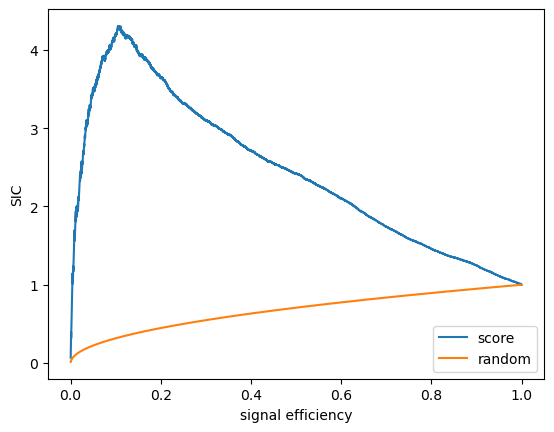

In [29]:
likelihood = np.nan_to_num(likelihood_, nan=0, posinf=0, neginf=0)        


sic_score , tpr_score , auc_score = SIC(label_test, likelihood)

plt.plot(tpr_score, sic_score, label='score')
plt.plot(tpr_score, tpr_score**0.5, label='random')
plt.xlabel('signal efficiency')
plt.ylabel('SIC')

plt.legend(loc='lower right')
plt.show()


In [23]:
# drawing samples at the same conditional values as the inner data (sanity check)
m_vals = x_test_CR[:, 0]
samples = model.sample(m_vals[0:10000])
print(samples.shape)
samples = torch.tensor(samples)
preprocessing_params = pre_parameters.copy()
for key in preprocessing_params.keys():
    preprocessing_params[key] = torch.tensor(preprocessing_params[key])

phyiscal_samples = inverse_standardize(samples, preprocessing_params["mean"], preprocessing_params["std"])
phyiscal_samples = inverse_logit_transform(phyiscal_samples, preprocessing_params["min"], preprocessing_params["max"])

phyiscal_samples = np.hstack([x_test_CR[:, 0:1][0:100], phyiscal_samples, phyiscal_samples[:, -1:]])

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.89 GiB total capacity; 12.37 GiB already allocated; 13.88 MiB free; 12.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

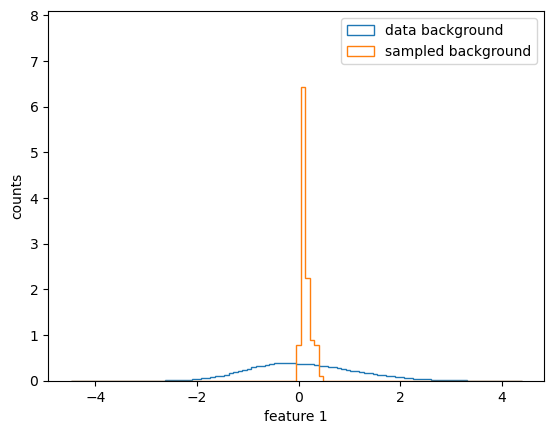

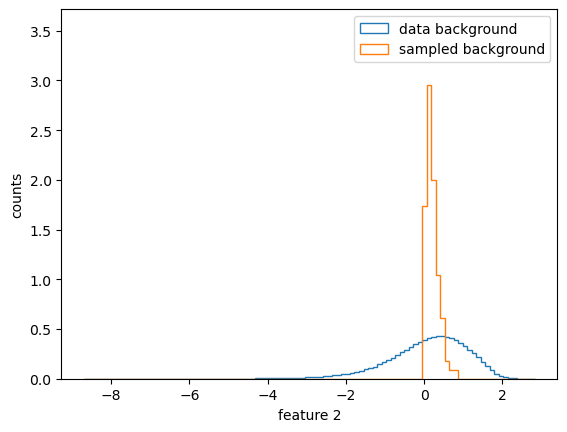

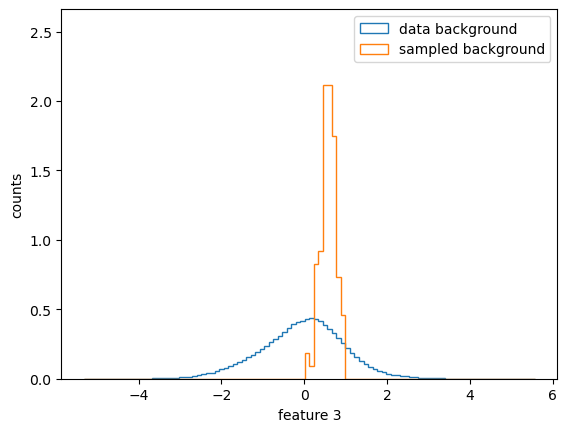

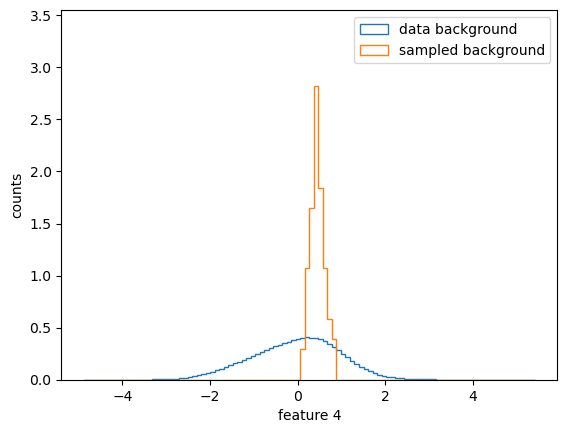

In [22]:
# comparing samples to inner background (sanity check)
for i in range(1, 5):
    _, binning, _ = plt.hist(x_test_CR[x_test_CR[:, -1] == 0, i], bins=100, label="data background", density=True, histtype="step")
    _ = plt.hist(phyiscal_samples[:, i], bins=binning, label="sampled background", density=True, histtype="step")
    plt.legend()
    plt.ylim(0, plt.gca().get_ylim()[1] * 1.2)
    plt.xlabel("feature {}".format(i))
    plt.ylabel("counts")
    plt.show()


In [32]:
# evaluate likelihood of inner data points
logit_log_prob = model.log_probs(
    preprocessed_innerdata_test[:, 0],
    preprocessed_innerdata_test[:, 1:-1]
)

# translating it to physical coordinates
log_prob = logit_log_prob + np.sum(
    np.log(
        2 * (1 + np.cosh(preprocessed_innerdata_test[:, 1:-1] * preprocessing_params["std"] + preprocessing_params["mean"]))
        / (preprocessing_params["std"] * (preprocessing_params["max"] - preprocessing_params["min"]))
    ), axis=1
)

In [33]:
print(log_prob)

[4.79555547 3.3325226  2.58020505 ... 3.83912673 3.29012089 3.36853826]
